<a href="https://colab.research.google.com/github/Tabonnu/EBM/blob/main/CRBM/pra1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

モデルの構築　→　異常度の定義　→　闘値の設定　→　モデルの検証

In [ ]:
"""
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime
from datetime import datetime
from zipfile import ZipFile
from urllib.request import urlretrieve

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error

'''Algos'''
import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
from tensorflow import keras
K = keras.backend

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, Lambda
from tensorflow.keras.layers import Embedding, Flatten, dot
from tensorflow.keras import regularizers
from tensorflow.keras.losses import mse, binary_crossentropy
"""

"\nimport numpy as np\nimport pandas as pd\nimport os, time, re\nimport pickle, gzip, datetime\nfrom datetime import datetime\nfrom zipfile import ZipFile\nfrom urllib.request import urlretrieve\n\n'''Data Viz'''\nimport matplotlib.pyplot as plt\nimport seaborn as sns\ncolor = sns.color_palette()\nimport matplotlib as mpl\n\n%matplotlib inline\n\n'''Data Prep and Model Evaluation'''\nfrom sklearn import preprocessing as pp\nfrom sklearn.model_selection import train_test_split \nfrom sklearn.model_selection import StratifiedKFold \nfrom sklearn.metrics import log_loss\nfrom sklearn.metrics import precision_recall_curve, average_precision_score\nfrom sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error\n\n'''Algos'''\nimport lightgbm as lgb\n\n'''TensorFlow and Keras'''\nimport tensorflow as tf\nfrom tensorflow import keras\nK = keras.backend\n\nfrom tensorflow.keras.models import Sequential, Model\nfrom tensorflow.keras.layers import Activation, Dense, Dropout\nfrom 

In [ ]:
"""
class RBM(object):
    
    def __init__(self, input_size, output_size, 
                 learning_rate, epochs, batchsize):
        # Define hyperparameters
        self._input_size = input_size #出力のサイズ
        self._output_size = output_size
        self.learning_rate = learning_rate#学習率
        self.epochs = epochs#エポック数
        self.batchsize = batchsize#バッチサイズ

        self.w = np.zeros([input_size, output_size], dtype=np.float32)
        self.hb = np.zeros([output_size], dtype=np.float32)
        self.vb = np.zeros([input_size], dtype=np.float32)

    def prob_h_given_v(self, visible, w, hb):#順方向パスの関数
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    def prob_v_given_h(self, hidden, w, vb):#逆方向パスの関数
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)

    def sample_prob(self, probs):#サンプリング関数
        return tf.nn.relu(tf.sign(probs - tf.random.uniform(tf.shape(probs))))
"""

'\nclass RBM(object):\n    \n    def __init__(self, input_size, output_size, \n                 learning_rate, epochs, batchsize):\n        # Define hyperparameters\n        self._input_size = input_size #出力のサイズ\n        self._output_size = output_size\n        self.learning_rate = learning_rate#学習率\n        self.epochs = epochs#エポック数\n        self.batchsize = batchsize#バッチサイズ\n\n        self.w = np.zeros([input_size, output_size], dtype=np.float32)\n        self.hb = np.zeros([output_size], dtype=np.float32)\n        self.vb = np.zeros([input_size], dtype=np.float32)\n\n    def prob_h_given_v(self, visible, w, hb):#順方向パスの関数\n        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)\n\n    def prob_v_given_h(self, hidden, w, vb):#逆方向パスの関数\n        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)\n\n    def sample_prob(self, probs):#サンプリング関数\n        return tf.nn.relu(tf.sign(probs - tf.random.uniform(tf.shape(probs))))\n'

・RBMはデータの生成をするため、正しい値との誤差を出すときに使うと思う
・RBMの条件付き独立性を有効に活用して可視変数と隠れ変数を交互にギブスサンプリングしようというもの
・ギブスサンプリングの改良版であるCD法

In [ ]:

!pip install git+https://github.com/omimo/xrbm.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/omimo/xrbm.git to /tmp/pip-req-build-fajpzl8d
  Running command git clone -q https://github.com/omimo/xrbm.git /tmp/pip-req-build-fajpzl8d
  Created wheel for xRBM: filename=xRBM-0.1.1-py2.py3-none-any.whl size=10717 sha256=9fb4217f278382dcf78e8cf6b61c37b6bd272f21e629460f47c997b4f95acee2
  Stored in directory: /tmp/pip-ephem-wheel-cache-15fe4bzl/wheels/e0/9e/08/7b5133acfff04d330180e5996b67974b01a20ab8cfbc4dcb78
  Created wheel for np: filename=np-1.0.2-py3-none-any.whl size=13676 sha256=d497b6297f878bf646239b41e93c12ebb25012c2fb0faeb2c2223291a15349eb
  Stored in directory: /root/.cache/pip/wheels/8d/31/5b/f3f27c678f2b3ad7e29903ed09bb7446717fd4c8b35f53973a
Successfully built xRBM np


In [ ]:
!pip install tensorflow==1.14

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109.3 MB 47 kB/s 
     |████████████████████████████████| 488 kB 53.7 MB/s 
     |████████████████████████████████| 50 kB 4.9 MB/s 
     |████████████████████████████████| 3.1 MB 37.9 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220527125636
    Uninstalling tensorflow-2.8.2+zzzcolab20220527125636:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab20220527125636
ERROR: pip's dependency resolver does not currently ta

In [ ]:
%tensorflow_version 1.4

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.4`. This will be interpreted as: `1.x`.


After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.


In [ ]:
import numpy as np
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
import xrbm.models#CRBMモデルクラスを含む
import xrbm.train#CRBMの学習に使用するCD-k近似アルゴリズムを含む
import xrbm.losses#学習過程をモニターするために使用する有効損失関数が含まれています

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



CRBMを用いたデモストレーションを行うために、周波数と振幅の異なるsin波を用いて簡単な4次元の時系列データを人工的に作成します。この人工データには少しノイズを加え、各インスタンスが他と少し異なるようにします。 ここで注目すべき主なパラメータはTIMESTEPSで、これはモデルが次のフレームを予測するために何フレーム見る必要があるか（モデルの順序）を表します。この例では、3 を使用しています。

In [ ]:
TIMESTEPS = 3 #見るフレーム数

NUM_DIM   = 4 #中間層の次元数
FREQS     = [20, 35, 50, 70] #周波数
AMPS      = [4, 1, 0.5, 2.5]
NSAMPLE   = 100
SEQ_LEN   = 2000 #フレーム数 #生成する数列に望む要素数。非負の数。

time_data = np.arange(SEQ_LEN) / 50 #np.arrange(stop) stopまで公差1の等差数列を作成 #https://note.nkmk.me/python-numpy-arange-linspace/

X_train   = []

print('Making dummy time series...') #ダミー時系列の作成
for i in range(NSAMPLE):
    x = [np.float32(
            np.sin(freq * time_data + np.random.rand()/2) *  
            (amp+np.random.rand())) 
         for freq, amp in zip(FREQS, AMPS)] #zip:forループの中で複数のイテラブルオブジェクト（リストやタプルなど）の要素を同時に取得して使いたい場合
    
    x = np.asarray(x) #リストをNumpy配列に変換する場合は、np.array、np.asarray #元のNumpy配列と同期され続けるコピーを作る場合は、np.asarrayを使う。
    x = x + np.random.rand(x.shape[0], x.shape[1]) * 1.2 #NumPy配列ndarrayの次元数:ndim #NumPy配列ndarrayの形状（各次元のサイズ:shape #NumPy配列ndarrayのサイズ（全要素数:size #NumPy配列ndarrayの最初の次元のサイズ: len()
    
    X_train.append(x.T)

X_train = np.asarray(X_train)

print(X_train.shape)

Making dummy time series...
(100, 2000, 4)


In [ ]:
print(time_data)

[0.000e+00 2.000e-02 4.000e-02 ... 3.994e+01 3.996e+01 3.998e+01]


なお、我々は100シリーズを作成し、それぞれ2000フレームを作成しました。つまり、我々のデータ（X_train）は、（100, 2000, 4）の形をしているのです

In [ ]:
_=plt.figure(figsize=(20,3)) #必要のない値(または一時的な変数)の代入先
_=plt.plot(X_train[0,0,1:200,,:]) #sequence[start:stop:step]

前述したように、各シーケンスにノイズを加えている。5つの系列の各次元を個別に描画して、どの程度のバリエーションがあるのか（あまりない！）把握しよう。

(-6.0, 6.0)

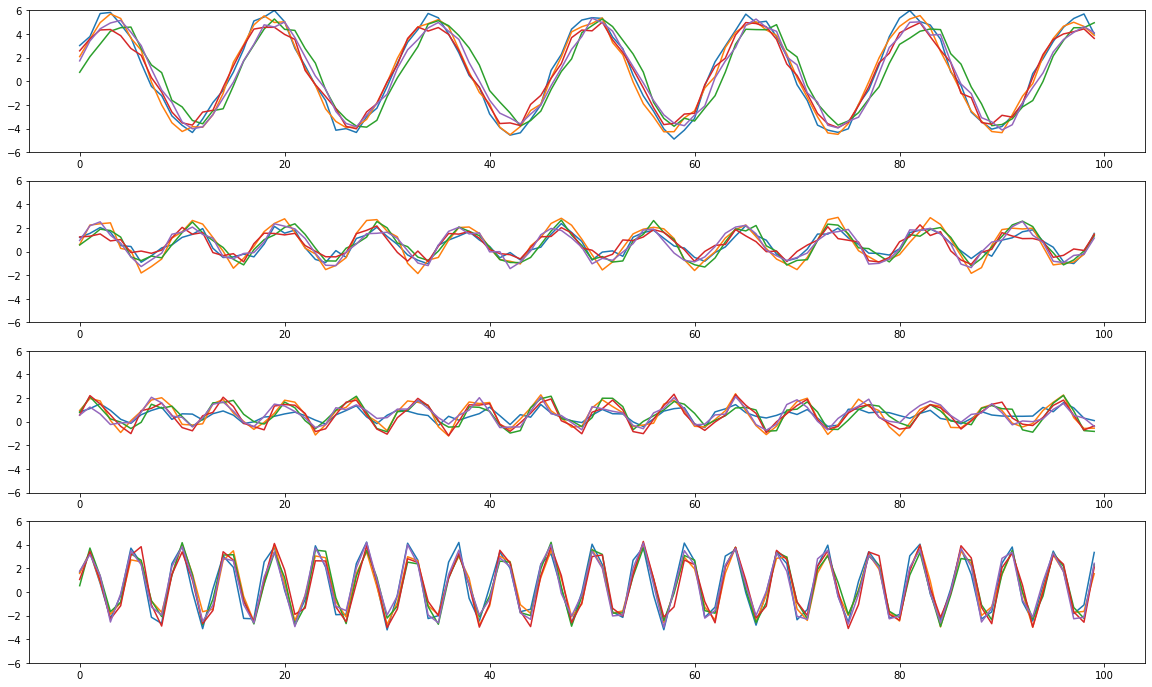

In [ ]:
fig=plt.figure(figsize=(20,12))#横2000ピクセル：縦1200ピクセル

fig.add_subplot(411) #411の意味は、4行目1列の1番目という意味
_=plt.plot(X_train[0:5,0:100,0].T)
plt.ylim(-6, 6)

fig.add_subplot(412)
_=plt.plot(X_train[0:5,0:100,1].T)
plt.ylim(-6, 6)

fig.add_subplot(413)
_=plt.plot(X_train[0:5,0:100,2].T)
plt.ylim(-6, 6)

fig.add_subplot(414)
_=plt.plot(X_train[0:5,0:100,3].T)
plt.ylim(-6, 6)

データをCRBMにフィードする前に、平均と単位分散がゼロになるようにデータを正規化する必要があります。

In [ ]:
X_train_flat = np.concatenate([m for m in X_train], axis=0) #複数の配列ndarrayを結合する #axisは次元(今回は0次元)
data_mean = np.mean(X_train_flat, axis=0) #平均を算出
data_std = np.std(X_train_flat, axis=0) #標準偏差を算出

X_train_normalized = [(d - data_mean) / data_std for d in X_train]

In [ ]:
print(X_train_flat)

[[ 3.03367654  1.19660504  0.82260257  1.66538503]
 [ 3.79188415  1.53882707  1.11001471  3.35754751]
 [ 5.74407521  2.03230233  1.51968296  0.71615799]
 ...
 [ 4.87971598  0.55961923 -1.17907683 -0.13602487]
 [ 5.45052463 -1.32887129  0.37967045  4.05790839]
 [ 5.65978264 -0.98478855  1.92746851  2.46105865]]


学習セットは条件データ（入力）と可視データ（モデルが予測する出力）の組で構成される。条件データは(TIMESTEPS, 4)の形状を持ち、可視データは(1, 4)の形状を持つ。

CRBMは条件データの各インスタンスが(1, _)の形状を持つことを期待する。そこで、条件データの各サンプルを連結（平坦化）し、(1 , 4*3) の形状を持つようにする。

In [ ]:
condition_data = []
visible_data = []

for m in X_train_normalized:
    for i in range(len(m)-TIMESTEPS):
        condition_data.append(m[i:i+TIMESTEPS].flatten())
        visible_data.append(m[i+TIMESTEPS])
        
condition_data = np.asarray(condition_data) #Numpy配列に変換する
visible_data = np.asarray(visible_data)

**CRBMインスタンスの作成**

 
CRBMモデルを作成し、可視ユニット、条件ユニット、隠れユニットの数を設定します。データは実数値なので、vis_typeをgaussianに設定します。また、Xavierイニシャライザを使用します

In [ ]:
num_vis         = visible_data.shape[1]
num_cond        = condition_data.shape[1]
num_hid         = 50
learning_rate   = 0.01
batch_size      = 100
training_epochs = 30
# Let's reset the tensorflow graph in case we want to rerun the code
tf.reset_default_graph()

crbm = xrbm.models.CRBM(num_vis=num_vis,
                        num_cond=num_cond,
                        num_hid=num_hid,
                        vis_type='gaussian',
                        initializer=tf.contrib.layers.xavier_initializer(),
                        name='crbm')

In [ ]:
batch_idxs = np.random.permutation(range(len(visible_data)))
n_batches  = len(batch_idxs) // batch_size

ミニバッチデータ（条件と可視データの両方）とモメンタムのプレースホルダーを作成します。

In [ ]:
batch_vis_data     = tf.placeholder(tf.float32, shape=(None, num_vis), name='batch_data')
batch_cond_data    = tf.placeholder(tf.float32, shape=(None, num_cond), name='cond_data')
momentum           = tf.placeholder(tf.float32, shape=())

CRBM の学習には CD-k アルゴリズムを使用します。このために、xrbm.trainモジュールからCDApproximatorのインスタンスを作成し、学習率、運動量、ギブス反復回数を渡します。 そして、CDApproximator の train メソッドを用いて、CRBM モデルとデータのプレースホルダを渡し、学習処理を定義します。




In [ ]:
cdapproximator     = xrbm.train.CDApproximator(learning_rate=learning_rate,
                                           momentum=momentum,
                                           k=1) # perform 1 step of gibbs sampling

train_op           = cdapproximator.train(crbm, vis_data=batch_vis_data, in_data=[batch_cond_data])

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





学習過程を監視するため、クロスエントロピー損失を用いて、各エポックにおけるモデルの再構成コストを計算する。

In [ ]:
reconstructed_data,_,_,_ = crbm.gibbs_sample_vhv(batch_vis_data, [batch_cond_data])
xentropy_rec_cost  = xrbm.losses.cross_entropy(batch_vis_data, reconstructed_data)



> **生成ループの作成**


モデルが学習されたら、crbm.predict()メソッドを用いて、前の3フレームから次のフレームを予測することができます。より簡単にするために、この操作を繰り返し、任意の長さの新しい時系列を生成する関数を作成することができます。以下の関数は基本的に3つのデータフレームを初期データとして取り込み、新しいデータフレームを予測し、生成されたデータを使って次のフレームを予測します。







In [ ]:
def generate(crbm, gen_init_frame = 100, num_gen = 200):
    gen_sample = []
    gen_hidden = []
    initcond = []

    gen_cond = tf.placeholder(tf.float32, shape=[1, num_cond], name='gen_cond_data')
    gen_init = tf.placeholder(tf.float32, shape=[1, num_vis], name='gen_init_data')
    gen_op = crbm.predict(gen_cond, gen_init, 2) # 2 stands for the number of gibbs sampling iterations

    for f in range(TIMESTEPS):
        gen_sample.append(np.reshape(visible_data[gen_init_frame+f], [1, num_vis]))

    print('Generating %d frames: '%(num_gen))

    for f in range(num_gen):
        initcond = np.asarray([gen_sample[s] for s in range(f,f+TIMESTEPS)]).ravel()

        initframes = gen_sample[f+TIMESTEPS-1] 
        
        feed = {gen_cond: np.reshape(initcond, [1,num_cond]).astype(np.float32),
                gen_init: initframes }
        
        s, h = sess.run(gen_op, feed_dict=feed)

        gen_sample.append(s)
        gen_hidden.append(h)

    gen_sample = np.reshape(np.asarray(gen_sample), [num_gen+TIMESTEPS,num_vis])
    gen_hidden = np.reshape(np.asarray(gen_hidden), [num_gen,num_hid])

    gen_sample = gen_sample * data_std + data_mean
    
    return gen_sample, gen_hidden

最後に、すべてを実行し、結果を見る準備が整いました。

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())


#     gen_sample, gen_hidden = generate(crbm, num_gen=70)
#     fig = plt.figure(figsize=(12, 3))
#     _ = plt.plot(gen_sample)
#     display.display(fig)

for epoch in range(training_epochs):

    if epoch < 5: # for the first 5 epochs, we use a momentum coeficient of 0 
        epoch_momentum = 0
    else: # once the training is stablized, we use a momentum coeficient of 0.9
        epoch_momentum = 0.9

    for batch_i in range(n_batches):
        # Get just minibatch amount of data
        idxs_i = batch_idxs[batch_i * batch_size:(batch_i + 1) * batch_size]

        feed = {batch_vis_data: visible_data[idxs_i],
                batch_cond_data: condition_data[idxs_i],
                momentum: epoch_momentum}

        # Run the training step
        sess.run(train_op, feed_dict=feed)

    reconstruction_cost = sess.run(xentropy_rec_cost, feed_dict=feed)


    print('Epoch %i / %i | Reconstruction Cost = %f'%
            (epoch+1, training_epochs, reconstruction_cost))

Epoch 1 / 30 | Reconstruction Cost = -3.212421
Epoch 2 / 30 | Reconstruction Cost = -3.220581
Epoch 3 / 30 | Reconstruction Cost = -3.210803
Epoch 4 / 30 | Reconstruction Cost = -3.183390
Epoch 5 / 30 | Reconstruction Cost = -3.177550
Epoch 6 / 30 | Reconstruction Cost = -3.214031
Epoch 7 / 30 | Reconstruction Cost = -3.226609
Epoch 8 / 30 | Reconstruction Cost = -3.222873
Epoch 9 / 30 | Reconstruction Cost = -3.216833
Epoch 10 / 30 | Reconstruction Cost = -3.190957
Epoch 11 / 30 | Reconstruction Cost = -3.174801
Epoch 12 / 30 | Reconstruction Cost = -3.223372
Epoch 13 / 30 | Reconstruction Cost = -3.196055
Epoch 14 / 30 | Reconstruction Cost = -3.183178
Epoch 15 / 30 | Reconstruction Cost = -3.209210
Epoch 16 / 30 | Reconstruction Cost = -3.220784
Epoch 17 / 30 | Reconstruction Cost = -3.175484
Epoch 18 / 30 | Reconstruction Cost = -3.165508
Epoch 19 / 30 | Reconstruction Cost = -3.207362
Epoch 20 / 30 | Reconstruction Cost = -3.239721
Epoch 21 / 30 | Reconstruction Cost = -3.216232
E

Generating 70 frames: 


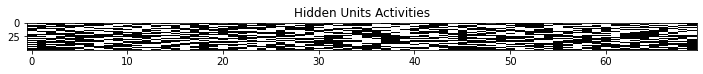

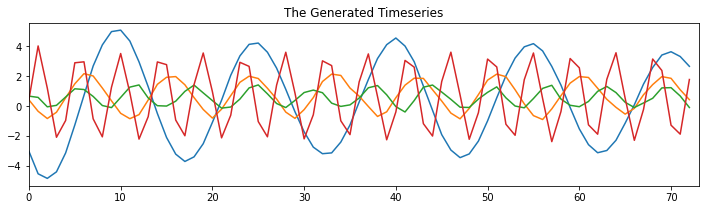

In [ ]:
gen_sample, gen_hidden = generate(crbm, num_gen=70)

fig = plt.figure(figsize=(12, 0.5))
_= plt.imshow(gen_hidden.T, cmap='gray', interpolation='nearest', aspect='auto')
plt.title('Hidden Units Activities')

fig = plt.figure(figsize=(12, 3))
_ = plt.plot(gen_sample)        
plt.title('The Generated Timeseries')
plt.xlim(0,73)

sess.close()

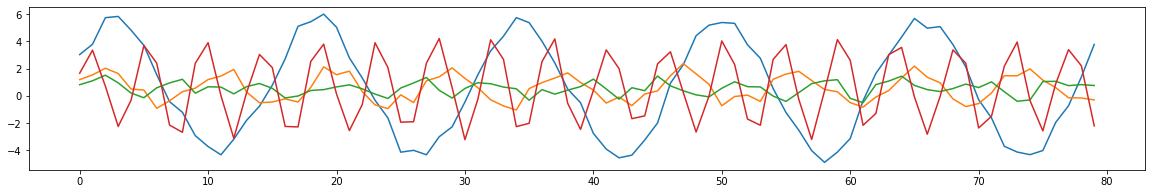

In [ ]:
_=plt.figure(figsize=(20,3))
_=plt.plot(X_train[0,0:80,:])